In [16]:
from sympy import *
import SQcircuit as sq
import Modules.SQcircuit_extensions as sq_ext
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Circuit's diagram

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground - asym coupling.jpg' width='500'>


In [2]:
# Numeric values
c_value   = 15
cJ_value  = 18
Lq_value  = 25
Lr_value  = 10
Δ_value  = 0.1

In [3]:
# Symbolic variables
c, α, cC, cJ, Lq, Lr, Δ = symbols('C, \\alpha, C_C, C_J^{\'}, L_q, L_r, Delta', real=True, positive=True, nonzero=True)
Lp = Lq/2 + Δ
Lm = Lq/2 - Δ
γ = simplify( 1/(Lp*Lm) / (1/Lr + 1/Lp + 1/Lm) )
l = 4*Lr/γ

In [6]:
L0 = Matrix([[ 1/Lm,      0,  -1/Lm             ],
            [    0,   1/Lp,  -1/Lp             ],
            [-1/Lm,  -1/Lp,  1/Lr + 1/Lp + 1/Lm]])

P1 = Matrix([[ 1,        0,  0],
             [ 0,        1,  0],
             [ γ*Lp,  γ*Lm,  0]])

C1 = Matrix([[α*cC + c + cJ,   -cJ],
            [ -cJ          ,  cC + c + cJ]])

## First transformation: Remove the third node from variables

In [9]:
L1 = nsimplify(simplify( P1.T * L0 * P1) )
L1 = L1[0:2,0:2]
L1

Matrix([
[2*(-2*Delta - L_q - 2*L_r)/(4*Delta**2 - L_q**2 - 4*L_q*L_r),                     4*L_r/(4*Delta**2 - L_q**2 - 4*L_q*L_r)],
[                     4*L_r/(4*Delta**2 - L_q**2 - 4*L_q*L_r), 2*(2*Delta - L_q - 2*L_r)/(4*Delta**2 - L_q**2 - 4*L_q*L_r)]])

## Second transformation: Diagonalize C matrix to decompose the hamiltonian in resonator + fluxonium

In [12]:
P2, _ = C1.diagonalize()
P2 = 0.5 * P2

# Dependance on the resonator and fluxonium hamiltonians with the Cc and α

In [14]:
# Create linspace arrays for alpha and cC
α_values = np.linspace(0, 1, 20)
cC_values = np.linspace(0, 100, 20)

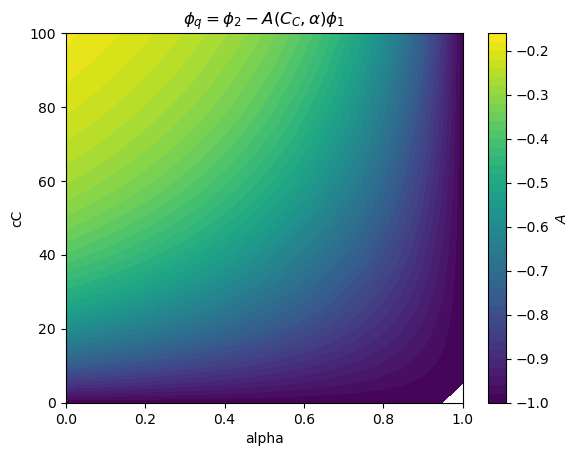

In [11]:
A = 2 * P2[1].subs([(c,c_value), (cJ,cJ_value), (Lq,Lq_value), (Lr,Lr_value), (Δ,Δ_value)])

# Evaluate the expression over the 2D grid
A_vs_α_Cc = np.empty((len(α_values), len(cC_values)))
for i, α_val in enumerate(α_values):
    for j, cC_val in enumerate(cC_values):
        A_vs_α_Cc[i, j] = A.subs({α: α_val, cC: cC_val})

# Plot the filled contours
plt.contourf(α_values, cC_values, A_vs_α_Cc.T, levels=50, cmap='viridis' )#, norm=TwoSlopeNorm(vmin=A_vs_α_Cc.min(), vcenter=-1, vmax=A_vs_α_Cc.max()))
plt.colorbar(label=r'$A$', ticks = np.linspace(-1,0,11))

plt.xlabel('alpha')
plt.ylabel('cC')
plt.title(r'$\phi_q = \phi_2 - A(C_C,\alpha)\phi_1$')
plt.show()

In [33]:
C2 = nsimplify(simplify( P2.T * C1 * P2) )
L2 = nsimplify(simplify( P2.T * L1 * P2) )

In [34]:
ωr = 1/sqrt(C2[0,0]*L2[0,0]**-1)/2/np.pi*1000
ωf = 1/sqrt(C2[1,1]*L2[1,1]**-1)/2/np.pi*1000
ωr.subs([(c,c_value), (cJ,cJ_value), (Lq,Lq_value), (Lr,Lr_value), (Δ,Δ_value), (cC,0)]).evalf(), ωf.subs([(c,c_value), (cJ,cJ_value), (Lq,Lq_value), (Lr,Lr_value), (Δ,Δ_value), (cC,0)]).evalf()

(7.20838819651165, 6.30355261686479)

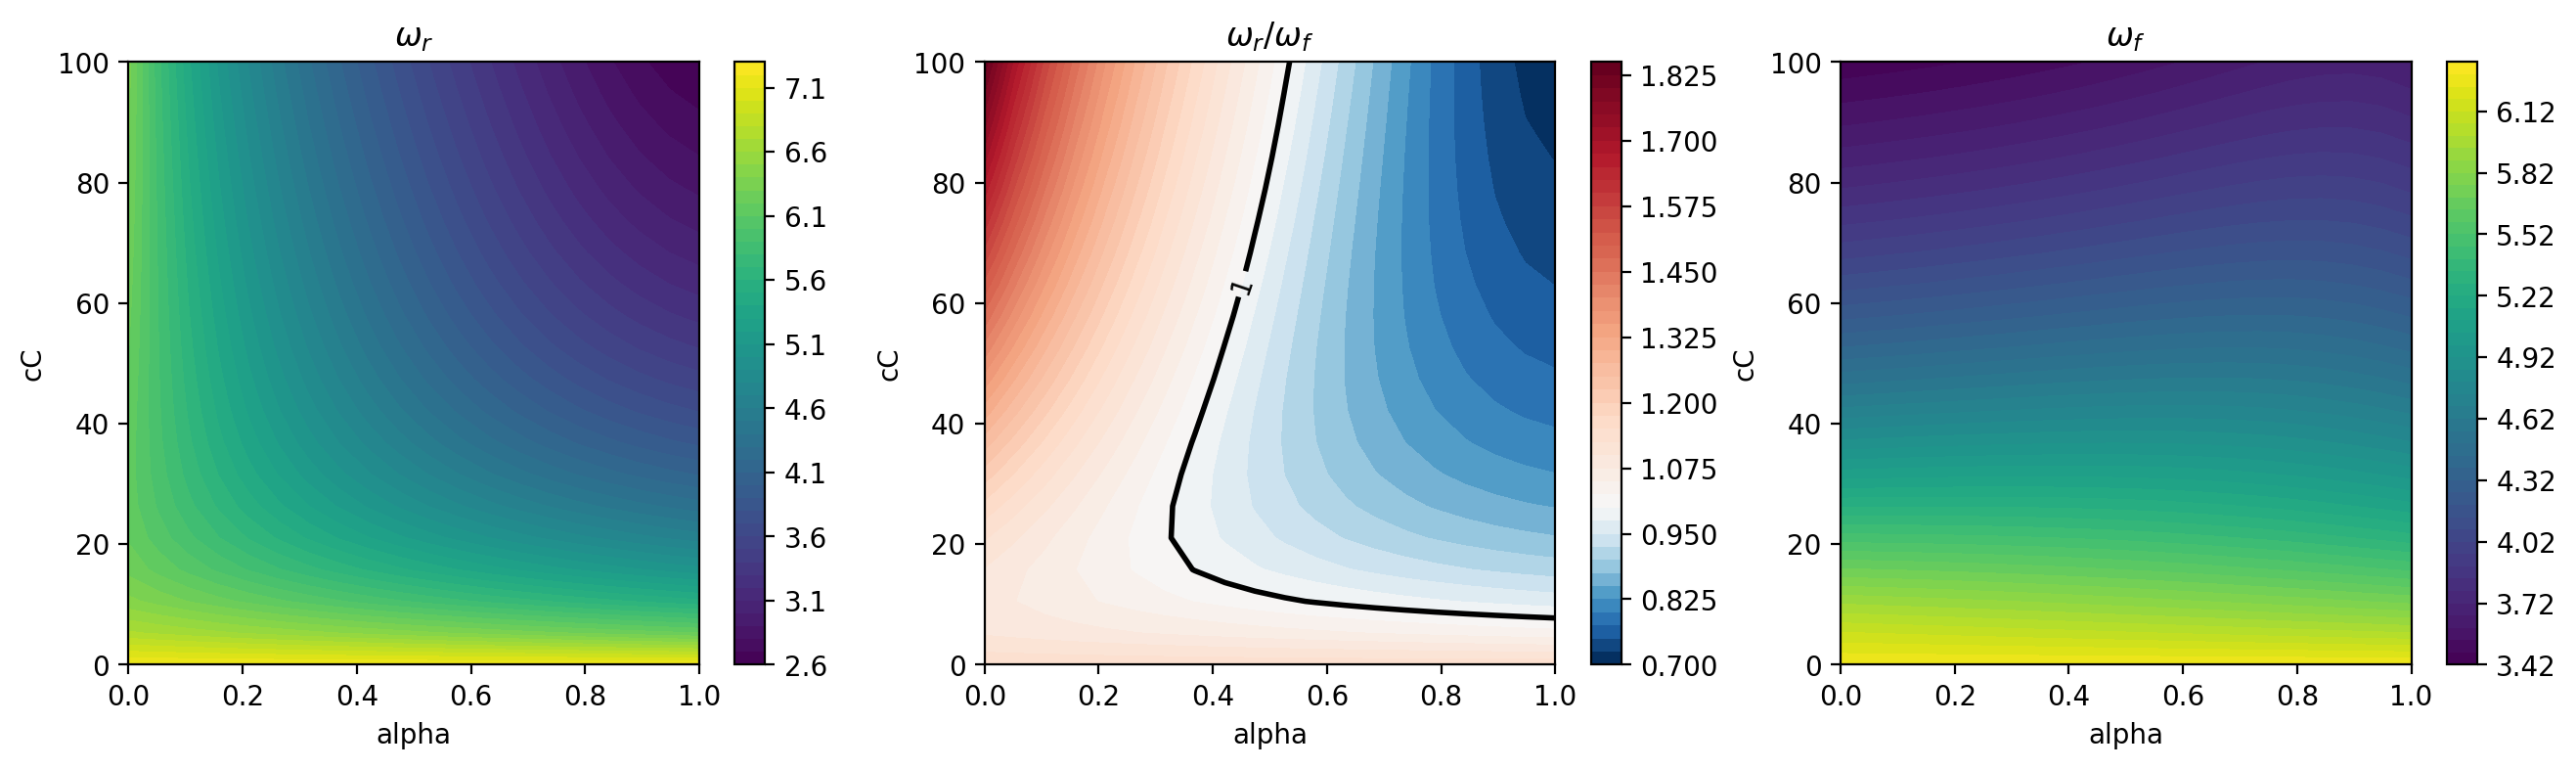

In [36]:
ωr_subs = ωr.subs([(c,c_value), (cJ,cJ_value), (Lq,Lq_value), (Lr,Lr_value), (Δ,Δ_value)])
ωf_subs = ωf.subs([(c,c_value), (cJ,cJ_value), (Lq,Lq_value), (Lr,Lr_value), (Δ,Δ_value)])

# Evaluate the expression over the 2D grid
ω_r_vs_α_Cc = np.empty((len(α_values), len(cC_values)))
ωr_by_ωf_vs_α_Cc = np.empty((len(α_values), len(cC_values)))
ω_f_vs_α_Cc = np.empty((len(α_values), len(cC_values)))
for i, α_val in enumerate(α_values):
    for j, cC_val in enumerate(cC_values):
        ω_r_vs_α_Cc[i, j] = ωr_subs.subs({α: α_val, cC: cC_val})
        ωr_by_ωf_vs_α_Cc[i, j] = (ωr_subs/ωf_subs).subs({α: α_val, cC: cC_val})
        ω_f_vs_α_Cc[i, j] = ωf_subs.subs({α: α_val, cC: cC_val})

titles = [r'$\omega_r $', r'$\omega_r / \omega_f$', r'$\omega_f$']
fig, ax = plt.subplots(ncols=3, figsize=[16,4], dpi=200)
for ax_i, Z, title in zip(ax, [ω_r_vs_α_Cc, ωr_by_ωf_vs_α_Cc, ω_f_vs_α_Cc], titles):
    if ax_i == ax[1]:
        cont = ax_i.contourf(α_values, cC_values, Z.T, levels=50, cmap='RdBu_r', norm=TwoSlopeNorm(vmin=Z.min(), vcenter=1, vmax=Z.max()))
        contour_line = ax_i.contour(α_values, cC_values, Z.T, levels=[1], colors='black', linewidths=2)
        ax_i.clabel(contour_line, inline=1, fontsize=10, fmt='%1.0f')
    else:
        cont = ax_i.contourf(α_values, cC_values, Z.T, levels=50, cmap='viridis')
    fig.colorbar(cont, ax=ax_i)
    ax_i.set_xlabel('alpha')
    ax_i.set_ylabel('cC')
    ax_i.set_title(title)

plt.show()

# Renormalization of the gap

In [25]:
# Create linspace arrays for alpha and cC
α_values = np.linspace(0, 1, 20)
cC_values = np.linspace(0, 100, 20)

In [27]:
# Evaluate the expression over the 2D grid
Δ01_vs_α_Cc = np.empty((len(α_values), len(cC_values))) 
anh_vs_α_Cc = np.empty((len(α_values), len(cC_values))) 

for i, α_val in enumerate(α_values):
    for j, cC_val in enumerate(cC_values):
        qubit = sq_ext.KITqubit_asym(Cc = cC_val, α = α_val)
        qubit.set_trunc_nums([1, 3, 10])
        _ = qubit.diag(3)
        Δ01_vs_α_Cc[i,j] = qubit.efreqs[1]-qubit.efreqs[0]
        Δ21 = qubit.efreqs[2]-qubit.efreqs[1]
        anh_vs_α_Cc[i,j] = Δ21 / Δ01_vs_α_Cc[i,j] - 1
        

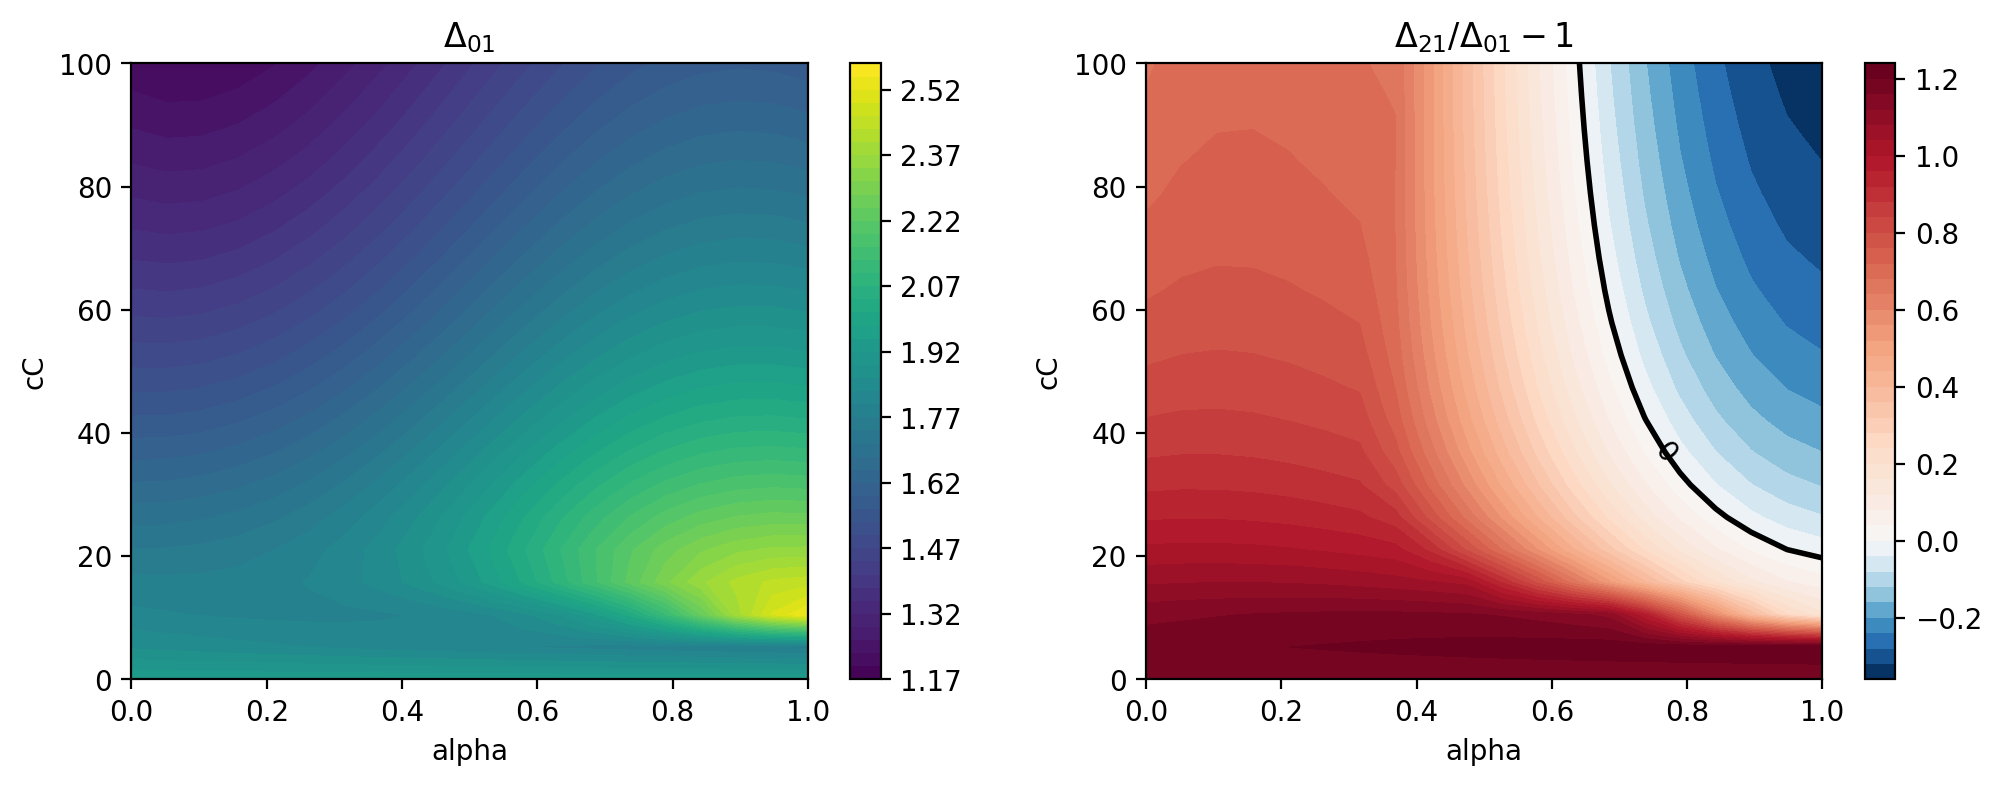

In [31]:
titles = [r'$\Delta_{01}$', r'$\Delta_{21}/\Delta_{01}-1$']
fig, ax = plt.subplots(ncols=2, figsize=[12,4], dpi=200)
for ax_i, Z, title in zip(ax, [Δ01_vs_α_Cc, anh_vs_α_Cc], titles):
    if ax_i == ax[1]:
        cont = ax_i.contourf(α_values, cC_values, Z.T, levels=50, cmap='RdBu_r', norm=TwoSlopeNorm(vmin=Z.min(), vcenter=0, vmax=Z.max()))
        contour_line = ax_i.contour(α_values, cC_values, Z.T, levels=[0], colors='black', linewidths=2)
        ax_i.clabel(contour_line, inline=0, fontsize=10, fmt='%1.0f')
    else:
        cont = ax_i.contourf(α_values, cC_values, Z.T, levels=50, cmap='viridis')
    fig.colorbar(cont, ax=ax_i)
    ax_i.set_xlabel('alpha')
    ax_i.set_ylabel('cC')
    ax_i.set_title(title)

plt.show()